<a href="https://colab.research.google.com/github/vinayprabhu/GaitID-2-SquatID/blob/master/GaitAcc2SquatGyr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1: Let's begin with the imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/gdrive')
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
os.chdir('/gdrive/My Drive/Colab Notebooks/Squat_classify')

2: Load the dataset

In [4]:
X_gyr=np.load('X_gyr_100.npy')
y_user=np.load('y_acc_100.npy')
print(X_gyr.shape,y_user.shape)

(587, 4, 100) (587,)


2B: Visualize the dataset:

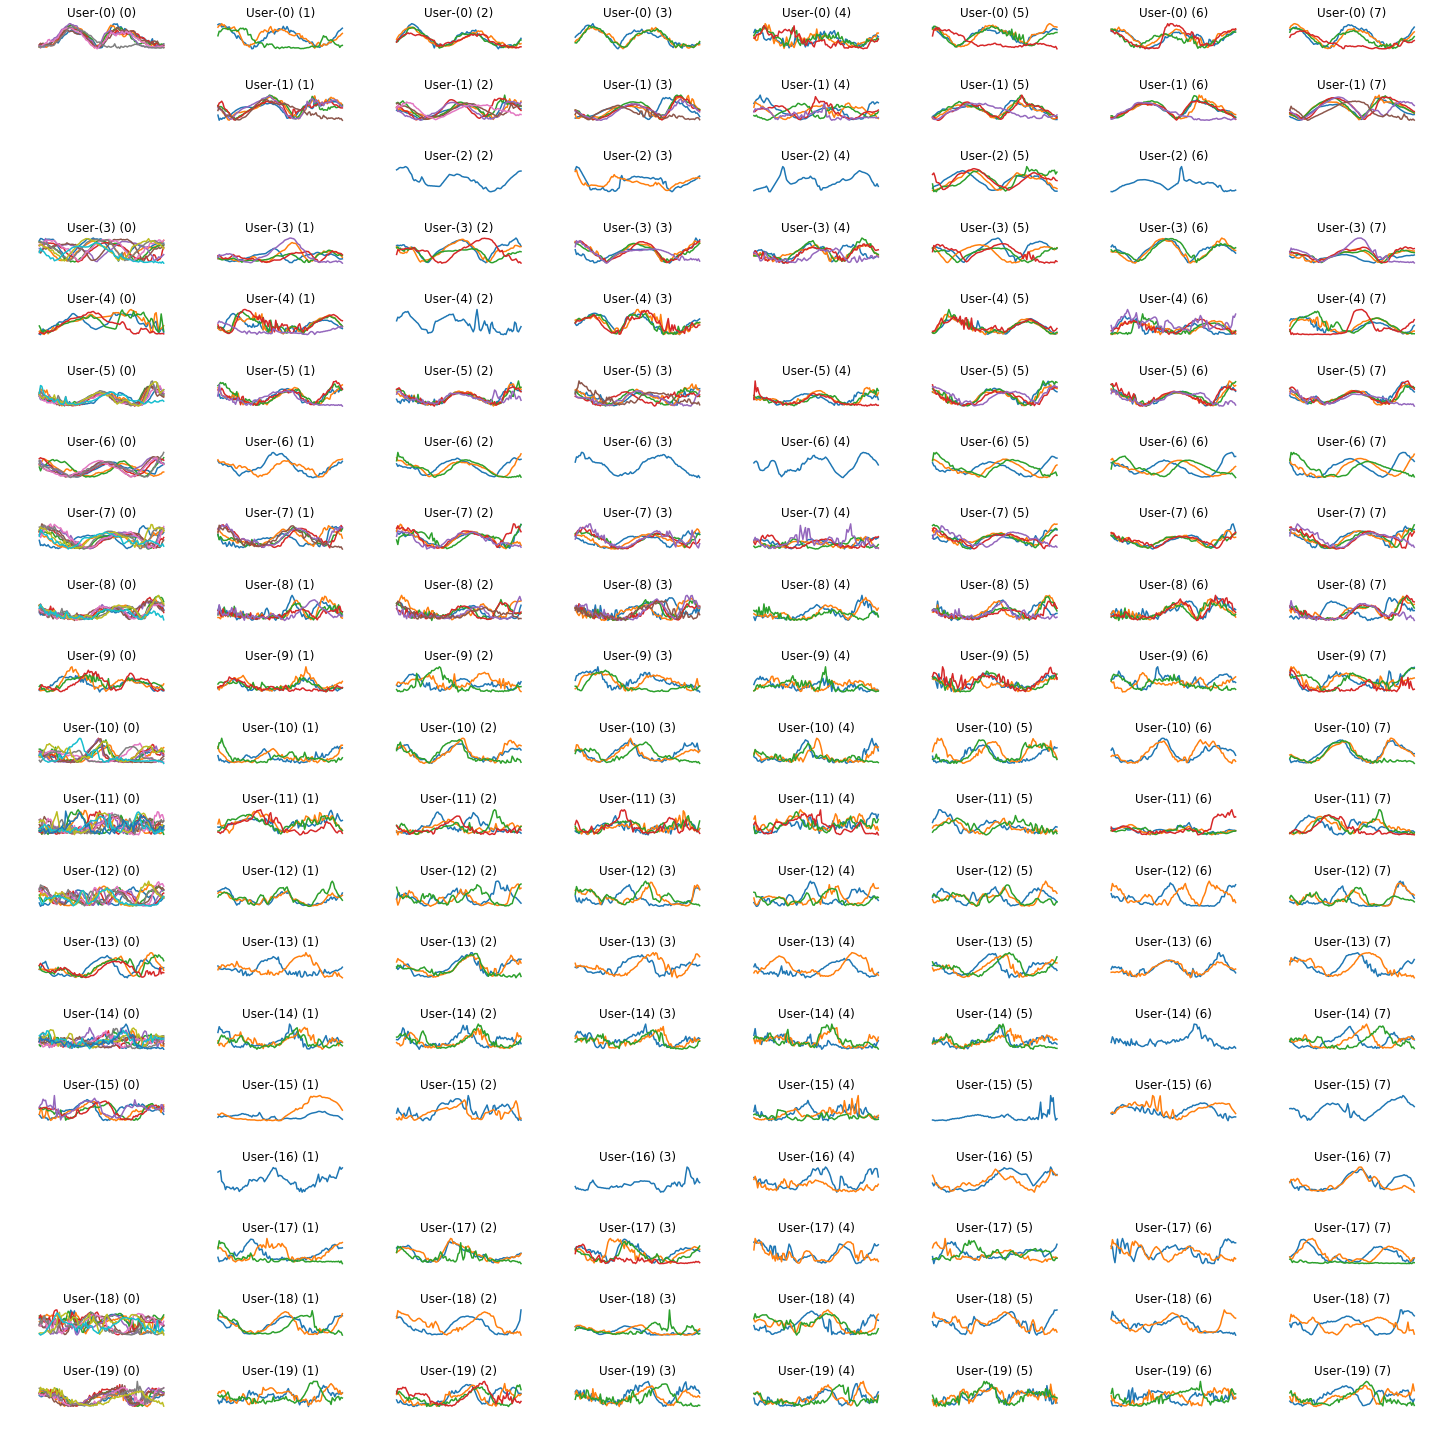

In [5]:
y_squat=np.load('type_labels.npy')

#####################################
plt.figure(figsize=(20,20))
c=0

for u in range(y_user.max()+1):

  for s in range(y_squat.max()+1):


    X_user_squat=X_gyr[(y_user==u)&(y_squat==s)]
    c+=1
    if(X_user_squat.shape[0]>0):
      
      plt.subplot(20,8,c)
      plt.plot(X_user_squat[:,3,:].T);
      plt.title(f'User-({u}) ({s})');
      plt.axis('off')

plt.tight_layout()
plt.savefig('gyro_grid.png',dpi=200)

3: Load the DeepGaitID model

In [6]:
from keras.models import load_model 
model=load_model('DeepGaitID.h5')
# model.summary()


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# from keras.utils import plot_model
# plot_model(model, to_file='DeepGaitID.png')

In [8]:
# Reshape the tensors to be fed into DeepGaitID
# Shape : N_squats x 1 x 4 x 100

X_gyr_100=np.expand_dims(X_gyr,1)
X_gyr_100.shape

(587, 1, 4, 100)

 Do the DeepGaitID features look *separated* enough in the tSNE vizualiation?

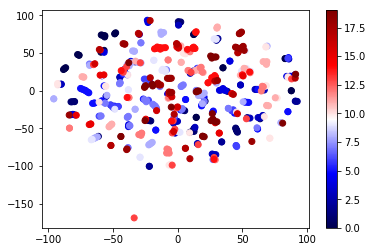

<Figure size 432x288 with 0 Axes>

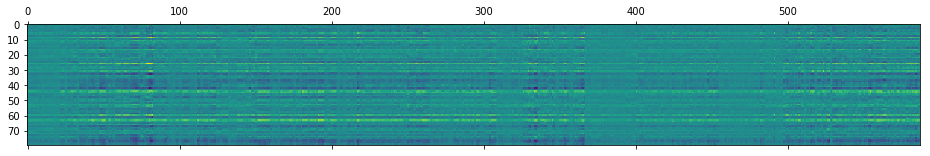

In [9]:
from keras.models import Model
from sklearn.manifold import TSNE as tsne

f_extract = Model(inputs=model.input,
                                 outputs=model.get_layer('feature_gen').output)
F_gyr_100 = f_extract.predict(X_gyr_100)
F_tsne_2= tsne(n_components=2,perplexity=1).fit_transform(F_gyr_100)
sc=plt.scatter(F_tsne_2[:,0],F_tsne_2[:,1],c=y_user,cmap='seismic')
plt.colorbar(sc)
plt.figure()
plt.matshow(F_gyr_100.T,aspect='auto')

In [0]:
# Use this for tensorflow projector
np.savetxt('F_gyr_100.tsv',F_gyr_100,delimiter='\t')
np.savetxt('y_gyr_100.tsv',y_user,delimiter='\t')

4: Transfer Learning:

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,PReLU
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras import backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit
num_classes=y_user.max()+1
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, test_index in sss.split(X_gyr_100, y_user):
   X_train, X_test = X_gyr_100[train_index], X_gyr_100[test_index]
   y_train, y_test = y_user[train_index], y_user[test_index]

print(X_train.shape,X_test.shape)
# convert class vectors to binary class matrices


batch_size = 8
num_classes = y_user.max()+1
epochs = 150

(352, 1, 4, 100) (235, 1, 4, 100)


In [29]:
from keras.models import load_model 

layer_dict = dict([(layer.name, layer) for layer in model.layers])
x = layer_dict['feature_gen'].output
x = Dense(256, activation='relu')(x)
x= Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x= Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)
from keras.models import Model
custom_model = Model(input=model.input, output=x)
# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
mcp_save = ModelCheckpoint('cnn_user-{val_acc:03f}.h5', save_best_only=True, monitor='val_acc', mode='max',verbose=1)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=4, verbose=1, epsilon=1e-4, mode='max')

Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

# label smoothing:
Y_train=(1-0.1)*Y_train+(0.1/num_classes)*np.ones(Y_train.shape)

history=custom_model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
          validation_data=(X_test, Y_test))
score = custom_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


history_1=custom_model.fit(X_train, Y_train,
          batch_size=64,
          epochs=10,
          verbose=0,
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
          validation_data=(X_test, Y_test))
score = custom_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '



Epoch 00001: val_acc improved from -inf to 0.77447, saving model to cnn_user-0.774468.h5

Epoch 00002: val_acc improved from 0.77447 to 0.80851, saving model to cnn_user-0.808511.h5

Epoch 00003: val_acc did not improve from 0.80851

Epoch 00004: val_acc improved from 0.80851 to 0.81702, saving model to cnn_user-0.817021.h5

Epoch 00005: val_acc improved from 0.81702 to 0.82553, saving model to cnn_user-0.825532.h5

Epoch 00006: val_acc did not improve from 0.82553

Epoch 00007: val_acc did not improve from 0.82553

Epoch 00008: val_acc did not improve from 0.82553

Epoch 00009: val_acc did not improve from 0.82553

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00010: val_acc improved from 0.82553 to 0.83404, saving model to cnn_user-0.834043.h5

Epoch 00011: val_acc improved from 0.83404 to 0.84681, saving model to cnn_user-0.846809.h5

Epoch 00012: val_acc improved from 0.84681 to 0.85106, saving model to cnn_user-0.851064.h5

Epoch 00013: v

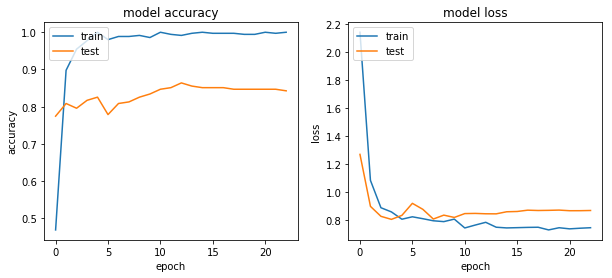

In [30]:
# summarize history for accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()
plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('train_test_loss_gyr.png',dpi=200)
# plt.show()

In [0]:
y_pred_mat=custom_model.predict(X_test)
y_pred=np.argmax(y_pred_mat,axis=1)

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       0.81      0.81      0.81        16
           2       0.43      0.75      0.55         4
           3       0.93      0.81      0.87        16
           4       1.00      0.45      0.62        11
           5       1.00      0.94      0.97        18
           6       0.89      0.80      0.84        10
           7       0.85      0.94      0.89        18
           8       0.82      1.00      0.90        18
           9       0.71      0.45      0.56        11
          10       0.83      0.83      0.83        12
          11       0.79      1.00      0.88        15
          12       0.92      1.00      0.96        12
          13       0.75      0.75      0.75         8
          14       1.00      1.00      1.00        12
          15       0.80      0.67      0.73         6
          16       0.00      0.00      0.00         3
          17       0.57    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


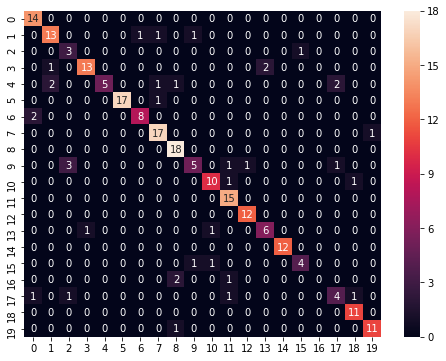

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
plt.savefig('conf_mat_gyr.png')